<a href="https://colab.research.google.com/github/louamlemjid/project06-humanoid-obj-manipulation/blob/master/humanoid_louamlemjid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supprimer le dossier repo dans colab !!!

In [ ]:
!rm -r project06-humanoid-obj-manipulation

importer le repo :

In [3]:
!git clone https://github.com/louamlemjid/project06-humanoid-obj-manipulation.git

Cloning into 'project06-humanoid-obj-manipulation'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 203 (delta 63), reused 174 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 6.19 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (63/63), done.


load model
**H1**

# Task
Install dm_control and its dependencies, then load the "h1.xml" MuJoCo model, create a physics environment, render the simulation, and display the rendering in the Colab notebook.

## Install dm control

### Subtask:
Install the `dm_control` library and its dependencies.


In [4]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Installing dm_control...')
!pip install -q dm_control>=1.0.31

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.31


**Reasoning**:
Install the `dm_control` library and its dependencies using pip.



In [5]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

## Import necessary libraries

### Subtask:
Import modules from `dm_control` and other required libraries.


In [6]:
#@title Other imports and helper functions

# General
import copy
import os
import time
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
# Access to enums and MuJoCo library functions.
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


**Reasoning**:
Import the necessary modules from dm_control and matplotlib as instructed.



## Load the mujoco model

### Subtask:
Load your `h1.xml` MuJoCo model using `dm_control`'s loading functions.


**Reasoning**:
Define the model path and load the MuJoCo model using `dm_control`.



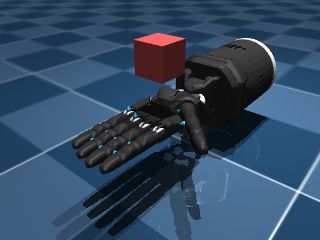

In [ ]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

### **DEBUT DE L'IMPLEMENTATION**

In [7]:
# src/sim/scene_builder.py

from dm_control import mujoco
import os
import PIL.Image
class SceneBuilder:
    """
    Responsible for building a complete MuJoCo scene directly
    from a given XML file.
    """

    @staticmethod
    def build(scene_xml_path: str) -> mujoco.Physics:
        """
        Loads and compiles a MuJoCo scene from a specified XML file.

        This is a static method, so you can call it directly on the class
        without creating an instance: `SceneBuilder.build_from_xml(...)`.

        Args:
            scene_xml_path: The full path to the scene's .xml file.

        Returns:
            A compiled dm_control.mujoco.Physics instance.

        Raises:
            FileNotFoundError: If the provided XML file path does not exist.
        """
        if not os.path.exists(scene_xml_path):
            raise FileNotFoundError(
                f"The specified scene file was not found: {scene_xml_path}"
            )

        print(f"Loading scene from: {scene_xml_path}")

        # The core function to load a model from a complete XML file.
        physics = mujoco.Physics.from_xml_path(scene_xml_path)

        print("Scene built successfully.")
        return physics

# instantiation

In [8]:
pathToModel = "./project06-humanoid-obj-manipulation/models/dex_hand/cube_scene.xml"
sceneBuilder = SceneBuilder()
physics = sceneBuilder.build(pathToModel)
physics

Loading scene from: ./project06-humanoid-obj-manipulation/models/dex_hand/cube_scene.xml
Scene built successfully.


# visualisation

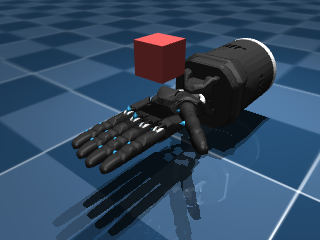

In [9]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

## dex hand class

In [10]:
physics.named.data.xpos

FieldIndexer(xpos):
                     x         y         z         
 0           world [ 0         0         0       ]
 1      lh_forearm [ 0         0         0       ]
 2        lh_wrist [ 0.213     0         0.01    ]
 3         lh_palm [ 0.247     0         0.01    ]
 4    lh_ffknuckle [ 0.342     0.033     0.01    ]
 5   lh_ffproximal [ 0.342     0.033     0.01    ]
 6     lh_ffmiddle [ 0.387     0.033     0.01    ]
 7     lh_ffdistal [ 0.412     0.033     0.01    ]
 8    lh_mfknuckle [ 0.346     0.011     0.01    ]
 9   lh_mfproximal [ 0.346     0.011     0.01    ]
10     lh_mfmiddle [ 0.391     0.011     0.01    ]
11     lh_mfdistal [ 0.416     0.011     0.01    ]
12    lh_rfknuckle [ 0.342    -0.011     0.01    ]
13   lh_rfproximal [ 0.342    -0.011     0.01    ]
14     lh_rfmiddle [ 0.387    -0.011     0.01    ]
15     lh_rfdistal [ 0.412    -0.011     0.01    ]
16 lh_lfmetacarpal [ 0.268    -0.033     0.01    ]
17    lh_lfknuckle [ 0.334    -0.033     0.01    ]
18   lh_lf

In [11]:
physics.named.data.qpos

FieldIndexer(qpos):
 0    lh_WRJ2 [ 0       ]
 1    lh_WRJ1 [ 0       ]
 2    lh_FFJ4 [ 0       ]
 3    lh_FFJ3 [ 0       ]
 4    lh_FFJ2 [ 0       ]
 5    lh_FFJ1 [ 0       ]
 6    lh_MFJ4 [ 0       ]
 7    lh_MFJ3 [ 0       ]
 8    lh_MFJ2 [ 0       ]
 9    lh_MFJ1 [ 0       ]
10    lh_RFJ4 [ 0       ]
11    lh_RFJ3 [ 0       ]
12    lh_RFJ2 [ 0       ]
13    lh_RFJ1 [ 0       ]
14    lh_LFJ5 [ 0       ]
15    lh_LFJ4 [ 0       ]
16    lh_LFJ3 [ 0       ]
17    lh_LFJ2 [ 0       ]
18    lh_LFJ1 [ 0       ]
19    lh_THJ5 [ 0       ]
20    lh_THJ4 [ 0       ]
21    lh_THJ3 [ 0       ]
22    lh_THJ2 [ 0       ]
23    lh_THJ1 [ 0       ]
24 cube_joint [ 0.3     ]
25 cube_joint [ 0       ]
26 cube_joint [ 0.1     ]
27 cube_joint [ 1       ]
28 cube_joint [ 0       ]
29 cube_joint [ 0       ]
30 cube_joint [ 0       ]

# Difference entre QPOS et XPOS ?????

In [13]:
physics.model.actuator_ctrlrange

array([[-0.523599,  0.174533],
       [-0.698132,  0.488692],
       [-1.0472  ,  1.0472  ],
       [ 0.      ,  1.22173 ],
       [-0.20944 ,  0.20944 ],
       [-0.698132,  0.698132],
       [-0.261799,  1.5708  ],
       [-0.349066,  0.349066],
       [-0.261799,  1.5708  ],
       [ 0.      ,  3.1415  ],
       [-0.349066,  0.349066],
       [-0.261799,  1.5708  ],
       [ 0.      ,  3.1415  ],
       [-0.349066,  0.349066],
       [-0.261799,  1.5708  ],
       [ 0.      ,  3.1415  ],
       [ 0.      ,  0.785398],
       [-0.349066,  0.349066],
       [-0.261799,  1.5708  ],
       [ 0.      ,  3.1415  ]])

In [14]:
# src/robot/base_robot.py
from abc import ABC, abstractmethod
import numpy as np
from dm_control import mujoco

class BaseRobot(ABC):
    """Abstract base class for any robot in the simulation."""

    def __init__(self, physics: mujoco.Physics):
        self._physics = physics
        self._model = physics.model
        self._controllable_joint_ids = []
        self._actuator_ids = []

    @property
    def physics(self) -> mujoco.Physics:
        return self._physics

    @property
    def model(self) -> mujoco.wrapper.core.MjModel:
        return self._model

    @property
    def controllable_joint_ids(self) -> list[int]:
        """Returns a list of MuJoCo IDs for joints controlled by this robot."""
        return self._controllable_joint_ids

    @property
    def actuator_ids(self) -> list[int]:
        """Returns a list of MuJoCo IDs for actuators controlling this robot."""
        return self._actuator_ids

    @property
    def action_space_limits(self) -> tuple[np.ndarray, np.ndarray]:
        """Returns (low, high) bounds for the robot's action space."""
        low = self._model.actuator_ctrlrange[self.actuator_ids, 0]
        high = self._model.actuator_ctrlrange[self.actuator_ids, 1]
        return low, high

    @abstractmethod
    def get_observation_data(self) -> np.ndarray:
        """Returns the part of the observation related to this robot's state."""
        pass

    @abstractmethod
    def set_commands(self, actions: np.ndarray):
        """Applies actions to the robot's actuators."""
        pass

    @abstractmethod
    def reset_state(self):
        """Resets the robot's joint positions and velocities to initial state."""
        pass
class DexHandRobot(BaseRobot):
    """Concrete implementation for the Dex Hand robot."""

    def __init__(self, physics: mujoco.Physics):
        super().__init__(physics)
        # Identify specific joint and actuator IDs for the Dex Hand
        # Filter for names starting with 'lh_' (left hand) and exclude wrist for finger-only control
        self._controllable_joint_ids = [5,4,3,2,18,17,16,15,14,9,8,
            7,6,13,12,11,10,23,22,21,20,19]
        self._actuator_ids = [9, 8, 7, 19, 18, 17, 16, 12, 11, 10, 15, 14, 13, 6, 5, 4, 3, 2]


        # Store initial qpos for the Dex Hand for reset (only for controllable joints)
        self._initial_qpos = self.physics.data.qpos[self.controllable_joint_ids].copy()

    def get_observation_data(self) -> np.ndarray:
        """Returns Dex Hand's qpos and qvel for controllable joints."""
        qpos_obs = self.physics.data.qpos[self.controllable_joint_ids]
        qvel_obs = self.physics.data.qvel[self.controllable_joint_ids]
        return np.concatenate([qpos_obs, qvel_obs]).astype(np.float32)

    def set_commands(self, actions: np.ndarray):
        """Applies actions (target joint positions) to Dex Hand actuators."""
        # Actions array should directly correspond to the order of actuator_ids
        for i, act_id in enumerate(self.actuator_ids):
            self.physics.data.ctrl[act_id] = actions[i]

    def reset_state(self):
        """Resets the Dex Hand's joint positions and velocities."""
        # Set qpos for controllable joints to their initial state
        self.physics.data.qpos[self.controllable_joint_ids] = self._initial_qpos
        # Set qvel for controllable joints to zero
        self.physics.data.qvel[self.controllable_joint_ids] = 0.0

# instantiation dex hand

In [15]:
robot = DexHandRobot(physics)
robot.get_observation_data()

array([-6.3581258e-02,  1.3704802e+00, -5.4658931e-03,  2.6656475e-03,
       -6.3595913e-02,  1.3704872e+00, -6.1908746e-03,  5.7373069e-05,
       -7.0676242e-04, -6.3583568e-02,  1.3704751e+00, -5.4941089e-03,
       -8.9541507e-05,  1.3704677e+00, -6.0264908e-02, -1.4804831e-02,
        9.0959456e-06,  1.3540538e-03,  1.3581306e+00, -9.5879566e-03,
        1.2780966e-01, -2.5148556e-01, -1.6446991e-02, -1.2891633e+01,
        3.3544775e-03, -3.2751034e-03, -1.6092790e-02, -1.2888098e+01,
        1.3383325e-02, -1.9830132e-03, -4.5220017e-02, -1.6399488e-02,
       -1.2894167e+01,  2.5529473e-03,  4.4631436e-03, -1.2897877e+01,
       -1.9687908e-02,  2.6285085e-03, -4.5854189e-03, -2.4243440e-03,
       -1.9066408e+01, -2.0058618e-01,  1.0845219e+00, -1.0138612e+00],
      dtype=float32)

## object class

In [16]:
# src/objects/base_object.py
from abc import ABC, abstractmethod
import numpy as np
from dm_control import mujoco

class BaseObject(ABC):
    """Abstract base class for any manipulable object."""

    def __init__(self, physics: mujoco.Physics, object_config: dict):
        self._physics = physics
        self._model = physics.model
        self._object_config = object_config
        self._body_id = self._model.name2id('cube','body')
        self._joint_id = self._model.name2id('cube_joint','joint')

    @property
    def physics(self) -> mujoco.Physics:
        return self._physics

    @property
    def model(self) -> mujoco.wrapper.core.MjModel:
        return self._model

    @property
    def body_id(self) -> int:
        return self._body_id

    @property
    def joint_id(self) -> int:
        return self._joint_id

    @abstractmethod
    def get_observation_data(self) -> np.ndarray:
        """Returns the part of the observation related to this object's state."""
        pass

    @abstractmethod
    def reset_state(self):
        """Resets the object's position and orientation to an initial (possibly randomized) state."""
        pass

# src/objects/cube_object.py
import numpy as np
from dm_control import mujoco
class CubeObject(BaseObject):
    """Concrete implementation for a manipulable cube object."""

    def __init__(self, physics: mujoco.Physics, object_config: dict):
        super().__init__(physics, object_config)
        self._initial_pos_relative = np.array(object_config["initial_pos_relative"])
        self._pos_randomization_range = {
            k: np.array(v) for k, v in object_config["pos_randomization_range"].items()
        }

    def get_observation_data(self) -> np.ndarray:
        """Returns cube's position, orientation, linear and angular velocities."""
        object_pos = self._physics.data.xpos[self._body_id]
        object_quat = self._physics.data.xquat[self._body_id]
        object_lin_vel = self._physics.data.object_velocity(self.body_id,'body')[0]
        object_ang_vel = self._physics.data.object_velocity(self.body_id,'body')[1]
        return np.concatenate([object_pos, object_quat, object_lin_vel, object_ang_vel]).astype(np.float32)

    def reset_state(self):
        """Resets the cube's position to initial (with randomization) and velocity to zero."""
        object_initial_qpos_idx = self._model.jnt_qposadr[self.joint_id]

        # Apply randomization to initial position
        random_offset_x = np.random.uniform(self._pos_randomization_range['x'][0], self._pos_randomization_range['x'][1])
        random_offset_y = np.random.uniform(self._pos_randomization_range['y'][0], self._pos_randomization_range['y'][1])
        random_offset_z = np.random.uniform(self._pos_randomization_range['z'][0], self._pos_randomization_range['z'][1])

        new_pos = self._initial_pos_relative + np.array([random_offset_x, random_offset_y, random_offset_z])

        # Set the object's position (first 3 values of its free joint qpos)
        self._physics.data.qpos[object_initial_qpos_idx:object_initial_qpos_idx+3] = new_pos
        # Set the object's orientation (quaternion, next 4 values). Keep it upright.
        self._physics.data.qpos[object_initial_qpos_idx+3:object_initial_qpos_idx+7] = np.array([1.0, 0.0, 0.0, 0.0]) # WXYZ identity quaternion

        # Reset object's velocities (6 values for a free joint)
        object_initial_qvel_idx = self._model.jnt_dofadr[self.joint_id]
        self._physics.data.qvel[object_initial_qvel_idx:object_initial_qvel_idx+6] = 0.0

## Instantiation Object

In [17]:
object_config = {
    "initial_pos_relative": [0.0, 0.0, 0.0],
    "pos_randomization_range": {
        "x": [-0.1, 0.1],
        "y": [-0.02, 0.02],
    "z": [-0.005, 0.005]},
    "name": "cube" ,
  "joint_name": "cube_joint" ,
  "geom_name": "cube_geom",
  "size": [0.03, 0.04, 0.02],
    "rewards":{
            "object_height_factor": 100,
                "target_height": 0.06,
                "target_height_bonus": 500,
                "drop_penalty": 200
            },
       "env":{
           "hand_model_path": "models/dex_hand/scene.xml",
           "control_timestep": 0.002,
           "episode_duration": 2.0 # seconds
       },
    "rl":
    {
      "total_timesteps": 50000 ,# Keep low for initial test, increase to millions for actual training
      "log_dir": "./sac_hand_manipulation_logs/",
      "model_save_path": "./trained_models/hand_policy.zip",
      "learning_rate": 0.0003,
      "buffer_size": 10000,
      "learning_starts": 100, # Start learning quickly for test
      "train_freq": [1, "episode"],
      "gradient_steps": 1,
      "ent_coef": "auto",
      "save_freq": 5000, # How often to save checkpoints during training}
    }}

manipulable_object = CubeObject(physics, object_config)

In [18]:
manipulable_object.get_observation_data()

array([ 3.8657388e-01,  1.4473405e+00, -7.5107761e-02, -3.1532581e-33,
       -1.7366182e-25,  2.1784970e-19,  1.0000000e+00, -1.0924305e-20,
        9.5193670e-20,  7.5185007e-08,  3.1492801e-17, -5.2039855e-17,
        8.2122924e-30], dtype=float32)

### observation builder

In [19]:
# src/env/observation_builder.py
import numpy as np


class ObservationBuilder:
    """
    Responsible for building the complete observation array from various components.
    """
    def __init__(self, robot: BaseRobot, manipulable_object: BaseObject):
        self._robot = robot
        self._object = manipulable_object

    def build_observation(self) -> np.ndarray:
        """Collects observation data from robot and object and concatenates them."""
        robot_obs = self._robot.get_observation_data()
        object_obs = self._object.get_observation_data()

        obs = np.concatenate([
            robot_obs,
            object_obs,
        ]).astype(np.float32)
        return obs

## Instantiaiton observation builder

In [20]:
 observation_builder = ObservationBuilder(robot, manipulable_object)
 observation_builder.build_observation()

array([-6.3581258e-02,  1.3704802e+00, -5.4658931e-03,  2.6656475e-03,
       -6.3595913e-02,  1.3704872e+00, -6.1908746e-03,  5.7373069e-05,
       -7.0676242e-04, -6.3583568e-02,  1.3704751e+00, -5.4941089e-03,
       -8.9541507e-05,  1.3704677e+00, -6.0264908e-02, -1.4804831e-02,
        9.0959456e-06,  1.3540538e-03,  1.3581306e+00, -9.5879566e-03,
        1.2780966e-01, -2.5148556e-01, -1.6446991e-02, -1.2891633e+01,
        3.3544775e-03, -3.2751034e-03, -1.6092790e-02, -1.2888098e+01,
        1.3383325e-02, -1.9830132e-03, -4.5220017e-02, -1.6399488e-02,
       -1.2894167e+01,  2.5529473e-03,  4.4631436e-03, -1.2897877e+01,
       -1.9687908e-02,  2.6285085e-03, -4.5854189e-03, -2.4243440e-03,
       -1.9066408e+01, -2.0058618e-01,  1.0845219e+00, -1.0138612e+00,
        3.8657388e-01,  1.4473405e+00, -7.5107761e-02, -3.1532581e-33,
       -1.7366182e-25,  2.1784970e-19,  1.0000000e+00, -1.0924305e-20,
        9.5193670e-20,  7.5185007e-08,  3.1492801e-17, -5.2039855e-17,
      

## reward component

In [21]:
physics.data.xpos[manipulable_object.body_id]

array([ 0.38657388,  1.44734049, -0.07510776])

In [22]:
# src/env/reward_components.py
import numpy as np
from dm_control import mujoco

# Define individual reward functions here.
# Each function takes physics, relevant object_body_id, and config.

def object_height_reward(physics: mujoco.Physics, object_body_id: int, config: dict) -> float:
    """Rewards the agent based on the object's height."""
    object_height = physics.data.xpos[object_body_id][2] # Z-coordinate
    reward = config.get("object_height_factor", 100) * (object_height - 0.05) # Assume table is at Z=0.05
    return float(reward)

def target_height_bonus_reward(physics: mujoco.Physics, object_body_id: int, config: dict) -> float:
    """Gives a bonus if the object reaches a target height."""
    object_height = physics.data.xpos[object_body_id][2]
    if object_height >= config.get("target_height", 0.06):
        return float(config.get("target_height_bonus", 500))
    return 0.0

def drop_penalty_reward(physics: mujoco.Physics, object_body_id: int, config: dict) -> float:
    """Penalizes the agent if the object falls too low."""
    object_height = physics.data.xpos[object_body_id][2]
    if object_height < config.get("drop_threshold", 0.02): # Below a very low threshold
        return float(-config.get("drop_penalty", 200))
    return 0.0

## Reward Composer

In [23]:
# src/env/reward_composer.py
from typing import Callable, List
from dm_control import mujoco

class RewardComposer:
    """
    Composes multiple individual reward components into a single total reward.
    """
    def __init__(self, physics: mujoco.Physics, object_body_id: int, reward_config: dict):
        self._physics = physics
        self._object_body_id = object_body_id
        self._reward_config = reward_config

        # Define the list of active reward functions to use
        self._reward_functions: List[Callable[[mujoco.Physics, int, dict], float]] = [
            object_height_reward,
            target_height_bonus_reward,
            drop_penalty_reward,
        ]

    def get_total_reward(self) -> float:
        """Calculates the sum of all active reward components."""
        total_reward = 0.0
        for func in self._reward_functions:
            total_reward += func(self._physics, self._object_body_id, self._reward_config)
        return total_reward

# Instantiation Reward Composer

In [24]:
reward_composer = RewardComposer(physics, manipulable_object.body_id, object_config["rewards"])
reward_composer.get_total_reward()

-212.5107757478041

## Hand manipulation environment

In [25]:
robot.action_space_limits

(array([ 0.      , -0.261799, -0.349066,  0.      , -0.261799, -0.349066,
         0.      ,  0.      , -0.261799, -0.349066,  0.      , -0.261799,
        -0.349066, -0.261799, -0.698132, -0.20944 ,  0.      , -1.0472  ]),
 array([3.1415  , 1.5708  , 0.349066, 3.1415  , 1.5708  , 0.349066,
        0.785398, 3.1415  , 1.5708  , 0.349066, 3.1415  , 1.5708  ,
        0.349066, 1.5708  , 0.698132, 0.20944 , 1.22173 , 1.0472  ]))

In [26]:
# src/env/hand_manipulation_env.py
import gymnasium as gym
from gymnasium import spaces
from dm_control import mujoco
import numpy as np

class HandManipulationEnv(gym.Env):
    """
    Gymnasium environment for Dex Hand object manipulation.
    Orchestrates the robot, object, observation, and reward components.
    """
    def __init__(self, physics: mujoco.Physics,
                 robot: BaseRobot,
                 manipulable_object: BaseObject,
                 observation_builder: ObservationBuilder,
                 reward_composer: RewardComposer,
                 env_config: dict):

        super().__init__()
        self._physics = physics
        self._model = physics.model
        self._robot = robot
        self._object = manipulable_object
        self._observation_builder = observation_builder
        self._reward_composer = reward_composer
        self._env_config = env_config

        self.control_timestep = self._env_config["control_timestep"]
        self.episode_duration = self._env_config["episode_duration"]

        # Define Observation Space based on the ObservationBuilder
        dummy_obs = self._observation_builder.build_observation()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=dummy_obs.shape, dtype=np.float32)

        # Define Action Space based on the robot's action space limits
        low_action, high_action = self._robot.action_space_limits
        self.action_space = spaces.Box(low=low_action, high=high_action, dtype=np.float32)

        # Store full initial qpos/qvel for MuJoCo's direct reset,
        # then let robot/object components handle their specific parts.
        self._initial_qpos_all = self._physics.data.qpos.copy()
        self._initial_qvel_all = self._physics.data.qvel.copy()


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._physics.reset() # Reset MuJoCo's internal state to model defaults

        # Reset all qpos/qvel to known initial states (important for deterministic restarts)
        self._physics.data.qpos[:] = self._initial_qpos_all
        self._physics.data.qvel[:] = self._initial_qvel_all

        # Delegate reset logic to specific components
        self._robot.reset_state()
        self._object.reset_state()

        # Step physics a few times to stabilize after reset
        for _ in range(10): # Simulate 10 steps to allow physics to settle
            self._physics.step()

        observation = self._observation_builder.build_observation()
        info = {}
        return observation, info

    def step(self, action):
        # Clip actions to stay within the action space boundaries
        clipped_action = np.clip(action, self.action_space.low, self.action_space.high)

        # Apply actions to the robot's actuators
        self._robot.set_commands(clipped_action)

        # Simulate for 'num_substeps' to cover 'control_timestep' duration
        num_substeps = int(self.control_timestep / self._model.opt.timestep)
        for _ in range(num_substeps):
            self._physics.step()

        reward = self._reward_composer.get_total_reward()

        # Check for episode termination (time limit)
        terminated = False
        if self._physics.data.time >= self.episode_duration:
            terminated = True

        truncated = False # In gymnasium, time limits typically result in 'truncated=True' but for simplicity initially, 'terminated=True' works.

        observation = self._observation_builder.build_observation()
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self):
        # Render the MuJoCo scene for visualization
        return self._physics.render(width=640, height=480, camera_id=0) # You might need to adjust camera_id

    def close(self):
        # No explicit close needed for dm_control.Physics, but good practice
        pass

# Instantiation ENV GYM

In [27]:
env = HandManipulationEnv(
        physics=physics,
        robot=robot,
        manipulable_object=manipulable_object,
        observation_builder=observation_builder,
        reward_composer=reward_composer,
        env_config=object_config["env"]
    )

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## **Stabe Baseline3 class**

In [28]:
!pip install -q stable_baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 16.1 MB/s eta 0:00:00


In [29]:
# src/rl/rl_agent_manager.py
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env # Not used in this minimal test, but useful
from stable_baselines3.common.callbacks import CheckpointCallback
import os
import gymnasium as gym

class RLAgentManager:
    """Manages the lifecycle of an RL agent (training, saving, loading)."""

    def __init__(self, env: gym.Env, rl_config: dict):
        self._env = env
        self._rl_config = rl_config
        self._model = None

        os.makedirs(self._rl_config["log_dir"], exist_ok=True)
        os.makedirs(os.path.dirname(self._rl_config["model_save_path"]), exist_ok=True)

    def train_agent(self):
        """Initializes and trains the SAC agent."""
        print("Initializing SAC agent...")

        self._model = SAC(
            "MlpPolicy",
            self._env,
            verbose=1,
            learning_rate=self._rl_config["learning_rate"],
            buffer_size=self._rl_config["buffer_size"],
            learning_starts=self._rl_config["learning_starts"],
            train_freq=tuple(self._rl_config["train_freq"]),
            gradient_steps=self._rl_config["gradient_steps"],
            ent_coef=self._rl_config["ent_coef"],
            tensorboard_log=self._rl_config["log_dir"]
        )

        # Callbacks
        checkpoint_callback = CheckpointCallback(
            save_freq=self._rl_config["save_freq"],
            save_path=os.path.join(self._rl_config["log_dir"], "checkpoints"),
            name_prefix='sac_model'
        )

        print(f"Starting training for {self._rl_config['total_timesteps']} timesteps...")
        self._model.learn(
            total_timesteps=self._rl_config["total_timesteps"],
            progress_bar=True,
            callback=[checkpoint_callback]
        )
        print("Training finished!")
        self._model.save(self._rl_config["model_save_path"])
        print(f"Model saved to {self._rl_config['model_save_path']}")

    def evaluate_agent(self, num_episodes: int = 1, render: bool = True):
        """Evaluates the loaded agent."""
        if self._model is None:
            print("No model loaded. Please train or load an agent first.")
            return

        print(f"Evaluating agent for {num_episodes} episodes...")
        for i in range(num_episodes):
            obs, info = self._env.reset()
            done = False
            total_reward = 0
            frames = []
            while not done:
                action, _states = self._model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self._env.step(action)
                total_reward += reward
                if render:
                    frames.append(self._env.render())
                done = terminated or truncated
            print(f"Episode {i+1}: Total Reward = {total_reward:.2f}")
            # For Colab, you'd typically save frames and then display them as a video.
            # Example (if you have a helper function like display_video):
            # if render and frames:
            #     from your_utils_file import display_video
            #     display_video(frames, fps=1/self._env.control_timestep)
        print("Evaluation complete.")

## **instantiation**

In [30]:
rl_manager = RLAgentManager(env, object_config["rl"])
print("RL Agent Manager initialized.")

# --- Action: Train the agent ---
rl_manager.train_agent()

RL Agent Manager initialized.
Initializing SAC agent...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training for 50000 timesteps...
Logging to ./sac_hand_manipulation_logs/SAC_1


Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 990      |
|    ep_rew_mean     | -2.1e+05 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 638      |
|    time_elapsed    | 6        |
|    total_timesteps | 3960     |
| train/             |          |
|    actor_loss      | -10.3    |
|    critic_loss     | 4.03e+04 |
|    ent_coef        | 0.999    |
|    ent_coef_loss   | -0.0174  |
|    learning_rate   | 0.0003   |
|    n_updates       | 3        |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 990       |
|    ep_rew_mean     | -1.74e+05 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 679       |
|    time_elapsed    | 11        |
|    total_timesteps | 7920      |
| train/             |           |
|    actor_loss      | -10.3     |
|    critic_loss     | 5.31e+04  |
| 

Training finished!
Model saved to ./trained_models/hand_policy.zip


Load training

In [31]:
model_path = "./trained_models/hand_policy.zip"
model = SAC.load(model_path, env=env)
print(f"Model loaded from {model_path}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded from ./trained_models/hand_policy.zip


Video after training

In [38]:
# Imports
import numpy as np
from stable_baselines3 import SAC
from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

# Helper function to display video in Colab
def display_video(frames, framerate=30):
    import imageio
    from pathlib import Path
    import io

    video_path = "/tmp/simulation.mp4"
    imageio.mimsave(video_path, frames, fps=framerate)

    mp4 = open(video_path, 'rb').read()
    b64 = b64encode(mp4).decode('ascii')
    html = f'''
      <video width=640 height=480 controls>
            <source src="data:video/mp4;base64,{b64}" type="video/mp4">
      </video>
    '''
    return HTML(html)

# Setup
duration = 4      # seconds
framerate = 30    # Hz
max_steps = duration * framerate

# Load the trained model
model_path = "./trained_models/hand_policy.zip"
model = SAC.load(model_path, env=env)
print(f"✅ Model loaded from: {model_path}")

# Reset environment
obs, info = env.reset()
frames = []

# For rendering with joint visualization
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Collect frames
for _ in range(max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # Render and store frame
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)

    if terminated or truncated:
        print("Episode finished early.")
        break

# Display video
display_video(frames, framerate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Model loaded from: ./trained_models/hand_policy.zip
